# First step. To obtain Data Flow Graphs of programs in Py150 dataset.
# We'll use code from the official implementation of StructCoder. *Paper - "StructCoder: Structure-Aware Transformer for Code Generation"*
# Specifically, we'll focus on the data preprocessing step. In this paper, AST and DFG graphs are generated from the code to then be fed to their encoder along with the program text.
# CodeSearchNet corpus is used  ( *2 milllion <comment, code> pairs from opensource libraries hosted on GitHub with 6 programming languages including Python* )
# We'll be generating DFGs on Py150.

### Additional functions - secondary parsers for processing and cleaning of code

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install tree_sitter==0.20.2 --quiet
!pip install datasets --quiet

In [3]:
import re
from io import StringIO
import  tokenize
def remove_comments_and_docstrings(source,lang):
    if lang in ['python']:
        """
        Returns 'source' minus comments and docstrings.
        """
        io_obj = StringIO(source)
        out = ""
        prev_toktype = tokenize.INDENT
        last_lineno = -1
        last_col = 0
        for tok in tokenize.generate_tokens(io_obj.readline):
            token_type = tok[0]
            token_string = tok[1]
            start_line, start_col = tok[2]
            end_line, end_col = tok[3]
            ltext = tok[4]
            if start_line > last_lineno:
                last_col = 0
            if start_col > last_col:
                out += (" " * (start_col - last_col))
            # Remove comments:
            if token_type == tokenize.COMMENT:
                pass
            # This series of conditionals removes docstrings:
            elif token_type == tokenize.STRING:
                if prev_toktype != tokenize.INDENT:
            # This is likely a docstring; double-check we're not inside an operator:
                    if prev_toktype != tokenize.NEWLINE:
                        if start_col > 0:
                            out += token_string
            else:
                out += token_string
            prev_toktype = token_type
            last_col = end_col
            last_lineno = end_line
        temp=[]
        for x in out.split('\n'):
            if x.strip()!="":
                temp.append(x)

        code = '\n'.join(temp)
        pos = 0
        while pos<len(code):
            try:
                start = code[pos:].index('"""') + pos
                end = code[start+3:].index('"""') + start+3
                code = code[:start]+code[end+3:]
                pos = start
            except:
                break
        return re.sub(r"\r\n\s*\r\n",'\n',code)



    elif lang in ['ruby']:
        return source
    else:
        def replacer(match):
            s = match.group(0)
            if s.startswith('/'):
                return " " # note: a space and not an empty string
            else:
                return s
        pattern = re.compile(
            r'//.*?$|/\*.*?\*/|\'(?:\\.|[^\\\'])*\'|"(?:\\.|[^\\"])*"',
            re.DOTALL | re.MULTILINE
        )
        temp=[]
        for x in re.sub(pattern, replacer, source).split('\n'):
            if x.strip()!="":
                temp.append(x)
        return '\n'.join(temp)

def tree_to_token_index(root_node):
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        return [(root_node.start_point,root_node.end_point)]
    else:
        code_tokens=[]
        for child in root_node.children:
            code_tokens+=tree_to_token_index(child)
        return code_tokens

def tree_to_token_nodes(root_node):
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        return [root_node]
    else:
        code_tokens=[]
        for child in root_node.children:
            code_tokens+=tree_to_token_nodes(child)
        return code_tokens

def tree_to_variable_index(root_node,index_to_code):
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        index=(root_node.start_point,root_node.end_point)
        _,code=index_to_code[index]
        if root_node.type!=code:
            return [(root_node.start_point,root_node.end_point)]
        else:
            return []
    else:
        code_tokens=[]
        for child in root_node.children:
            code_tokens+=tree_to_variable_index(child,index_to_code)
        return code_tokens

def index_to_code_token(index,code):
    start_point=index[0]
    end_point=index[1]
    if start_point[0]==end_point[0]:
        s=code[start_point[0]][start_point[1]:end_point[1]]
    else:
        s=""
        s+=code[start_point[0]][start_point[1]:]
        for i in range(start_point[0]+1,end_point[0]):
            s+=code[i]
        s+=code[end_point[0]][:end_point[1]]
    return s

def detokenize_code(code):
        # replace recreate lines with \n and appropriate indent / dedent
        # removing indent/ dedent tokens
        assert isinstance(code, str) or isinstance(code, list)
        if isinstance(code, list):
            code = " ".join(code)
        code = code.replace("ENDCOM", "NEW_LINE")
        code = code.replace("▁", "SPACETOKEN")
        lines = code.split("NEW_LINE")
        tabs = ""
        for i, line in enumerate(lines):
            line = line.strip()
            if line.startswith("INDENT "):
                tabs += "    "
                line = line.replace("INDENT ", tabs)
            elif line.startswith("DEDENT"):
                number_dedent = line.count("DEDENT")
                tabs = tabs[4 * number_dedent :]
                line = line.replace("DEDENT", "")
                line = line.strip()
                line = tabs + line
            elif line == "DEDENT":
                line = ""
            else:
                line = tabs + line
            lines[i] = line
        untok_s = "\n".join(lines)
        # find string and comment with parser and detokenize string correctly
        try:
            for toktype, tok, _, _, line in tokenize.tokenize(
                BytesIO(untok_s.encode("utf-8")).readline
            ):
                if toktype == tokenize.STRING or toktype == tokenize.COMMENT:
                    tok_ = (
                        tok.replace("STRNEWLINE", "\n")
                        .replace("TABSYMBOL", "\t")
                        .replace(" ", "")
                        .replace("SPACETOKEN", " ")
                    )
                    untok_s = untok_s.replace(tok, tok_)
        except KeyboardInterrupt:
            raise
        except:
            # TODO raise ValueError(f'Invalid python function \n {code}\n')
            pass
#         # detokenize imports
#         untok_s = (
#             untok_s.replace(". ", ".")
#             .replace(" .", ".")
#             .replace("import.", "import .")
#             .replace("from.", "from .")
#         )
#         # special strings
#         string_modifiers = ["r", "u", "f", "rf", "fr", "b", "rb", "br"]
#         for modifier in string_modifiers + [s.upper() for s in string_modifiers]:
#             untok_s = untok_s.replace(f" {modifier} '", f" {modifier}'").replace(
#                 f' {modifier} "', f' {modifier}"'
#             )
#         untok_s = untok_s.replace("> >", ">>").replace("< <", "<<")
        return untok_s

### DFG generator for Python

In [4]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT license.

from tree_sitter import Language, Parser



def DFG_python(root_node,index_to_code,states):
    assignment=['assignment','augmented_assignment','for_in_clause']
    if_statement=['if_statement']
    for_statement=['for_statement']
    while_statement=['while_statement']
    do_first_statement=['for_in_clause']
    def_statement=['default_parameter']
    states=states.copy()
    if (len(root_node.children)==0 or root_node.type=='string') and root_node.type!='comment':
        idx,code=index_to_code[(root_node.start_point,root_node.end_point)]
        if root_node.type==code:
            return [],states
        elif code in states:
            return [(code,idx,'comesFrom',[code],states[code].copy())],states
        else:
            if root_node.type=='identifier':
                states[code]=[idx]
            return [(code,idx,'comesFrom',[],[])],states
    elif root_node.type in def_statement:
        name=root_node.child_by_field_name('name')
        value=root_node.child_by_field_name('value')
        DFG=[]
        if value is None:
            indexs=tree_to_variable_index(name,index_to_code)
            for index in indexs:
                idx,code=index_to_code[index]
                DFG.append((code,idx,'comesFrom',[],[]))
                states[code]=[idx]
            return sorted(DFG,key=lambda x:x[1]),states
        else:
            name_indexs=tree_to_variable_index(name,index_to_code)
            value_indexs=tree_to_variable_index(value,index_to_code)
            temp,states=DFG_python(value,index_to_code,states)
            DFG+=temp
            for index1 in name_indexs:
                idx1,code1=index_to_code[index1]
                for index2 in value_indexs:
                    idx2,code2=index_to_code[index2]
                    DFG.append((code1,idx1,'comesFrom',[code2],[idx2]))
                states[code1]=[idx1]
            return sorted(DFG,key=lambda x:x[1]),states
    elif root_node.type in assignment:
        if root_node.type=='for_in_clause':
            right_nodes=[root_node.children[-1]]
            left_nodes=[root_node.child_by_field_name('left')]
        else:
            if root_node.child_by_field_name('right') is None:
                return [],states
            left_nodes=[x for x in root_node.child_by_field_name('left').children if x.type!=',']
            right_nodes=[x for x in root_node.child_by_field_name('right').children if x.type!=',']
            if len(right_nodes)!=len(left_nodes):
                left_nodes=[root_node.child_by_field_name('left')]
                right_nodes=[root_node.child_by_field_name('right')]
            if len(left_nodes)==0:
                left_nodes=[root_node.child_by_field_name('left')]
            if len(right_nodes)==0:
                right_nodes=[root_node.child_by_field_name('right')]
        DFG=[]
        for node in right_nodes:
            temp,states=DFG_python(node,index_to_code,states)
            DFG+=temp

        for left_node,right_node in zip(left_nodes,right_nodes):
            left_tokens_index=tree_to_variable_index(left_node,index_to_code)
            right_tokens_index=tree_to_variable_index(right_node,index_to_code)
            temp=[]
            for token1_index in left_tokens_index:
                idx1,code1=index_to_code[token1_index]
                temp.append((code1,idx1,'computedFrom',[index_to_code[x][1] for x in right_tokens_index],
                             [index_to_code[x][0] for x in right_tokens_index]))
                states[code1]=[idx1]
            DFG+=temp
        return sorted(DFG,key=lambda x:x[1]),states
    elif root_node.type in if_statement:
        DFG=[]
        current_states=states.copy()
        others_states=[]
        tag=False
        if 'else' in root_node.type:
            tag=True
        for child in root_node.children:
            if 'else' in child.type:
                tag=True
            if child.type not in ['elif_clause','else_clause']:
                temp,current_states=DFG_python(child,index_to_code,current_states)
                DFG+=temp
            else:
                temp,new_states=DFG_python(child,index_to_code,states)
                DFG+=temp
                others_states.append(new_states)
        others_states.append(current_states)
        if tag is False:
            others_states.append(states)
        new_states={}
        for dic in others_states:
            for key in dic:
                if key not in new_states:
                    new_states[key]=dic[key].copy()
                else:
                    new_states[key]+=dic[key]
        for key in new_states:
            new_states[key]=sorted(list(set(new_states[key])))
        return sorted(DFG,key=lambda x:x[1]),new_states
    elif root_node.type in for_statement:
        DFG=[]
        for i in range(2):
            right_nodes=[x for x in root_node.child_by_field_name('right').children if x.type!=',']
            left_nodes=[x for x in root_node.child_by_field_name('left').children if x.type!=',']
            if len(right_nodes)!=len(left_nodes):
                left_nodes=[root_node.child_by_field_name('left')]
                right_nodes=[root_node.child_by_field_name('right')]
            if len(left_nodes)==0:
                left_nodes=[root_node.child_by_field_name('left')]
            if len(right_nodes)==0:
                right_nodes=[root_node.child_by_field_name('right')]
            for node in right_nodes:
                temp,states=DFG_python(node,index_to_code,states)
                DFG+=temp
            for left_node,right_node in zip(left_nodes,right_nodes):
                left_tokens_index=tree_to_variable_index(left_node,index_to_code)
                right_tokens_index=tree_to_variable_index(right_node,index_to_code)
                temp=[]
                for token1_index in left_tokens_index:
                    idx1,code1=index_to_code[token1_index]
                    temp.append((code1,idx1,'computedFrom',[index_to_code[x][1] for x in right_tokens_index],
                                 [index_to_code[x][0] for x in right_tokens_index]))
                    states[code1]=[idx1]
                DFG+=temp
            if  root_node.children[-1].type=="block":
                temp,states=DFG_python(root_node.children[-1],index_to_code,states)
                DFG+=temp
        dic={}
        for x in DFG:
            if (x[0],x[1],x[2]) not in dic:
                dic[(x[0],x[1],x[2])]=[x[3],x[4]]
            else:
                dic[(x[0],x[1],x[2])][0]=list(set(dic[(x[0],x[1],x[2])][0]+x[3]))
                dic[(x[0],x[1],x[2])][1]=sorted(list(set(dic[(x[0],x[1],x[2])][1]+x[4])))
        DFG=[(x[0],x[1],x[2],y[0],y[1]) for x,y in sorted(dic.items(),key=lambda t:t[0][1])]
        return sorted(DFG,key=lambda x:x[1]),states
    elif root_node.type in while_statement:
        DFG=[]
        for i in range(2):
            for child in root_node.children:
                temp,states=DFG_python(child,index_to_code,states)
                DFG+=temp
        dic={}
        for x in DFG:
            if (x[0],x[1],x[2]) not in dic:
                dic[(x[0],x[1],x[2])]=[x[3],x[4]]
            else:
                dic[(x[0],x[1],x[2])][0]=list(set(dic[(x[0],x[1],x[2])][0]+x[3]))
                dic[(x[0],x[1],x[2])][1]=sorted(list(set(dic[(x[0],x[1],x[2])][1]+x[4])))
        DFG=[(x[0],x[1],x[2],y[0],y[1]) for x,y in sorted(dic.items(),key=lambda t:t[0][1])]
        return sorted(DFG,key=lambda x:x[1]),states
    else:
        DFG=[]
        for child in root_node.children:
            if child.type in do_first_statement:
                temp,states=DFG_python(child,index_to_code,states)
                DFG+=temp
        for child in root_node.children:
            if child.type not in do_first_statement:
                temp,states=DFG_python(child,index_to_code,states)
                DFG+=temp

        return sorted(DFG,key=lambda x:x[1]),states




### Helper functions for loading and working with a corpus. Also some statistics.

In [5]:
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
tqdm.pandas()
import numpy as np
from tree_sitter import Language, Parser
import pickle
import os
from transformers import RobertaTokenizer
import matplotlib.pyplot as plt


def read_pt_dataset(max_samples_per_split=None):
    dataset = load_dataset('MaximTitarenkoUIT/py150_sample')
    rows = []

    for split in ['train']:
        num_samples_in_split = len(dataset[split])
        indices = list(range(num_samples_in_split))
        if (max_samples_per_split is not None) and (num_samples_in_split>max_samples_per_split):
            indices = list(map(int, np.random.choice(indices, max_samples_per_split, replace=False)))
        pbar = tqdm(indices)
        pbar.set_description('Reading split='+split)

        for i in pbar:
            sample = dataset[split][i]
            rows.append([sample['source_code'], 'python',
                         sample['path']])

    return pd.DataFrame(rows, columns=['code', 'lang', 'text'])


def add_php_ends(code):
    if not(code.startswith('<?php')):
        code="<?php "+code
    if not(code.endswith('?>')):
        code=code+"?>"
    return code


def print_lang_dist(langs, total=None):
    if total is None:
        total = len(langs)
    vc = pd.value_counts(langs)
    display(pd.DataFrame({'lang':vc.index, 'count':vc.values, 'perc':vc.values/total*100}))


def get_tokenizer_chars():
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    tokenizer_chars = []
    for i in range(tokenizer.vocab_size):
        token = tokenizer.decode(i)
        if len(token)==1:
            tokenizer_chars.append(token)
    tokenizer_chars = [c for c in tokenizer_chars if c!='�']
    return tokenizer_chars


def preprocess(data):
    codes = []
    failed_count = 0
    failed_langs = []
    rows = []
    tokenizer_chars = get_tokenizer_chars()
    pbar = tqdm(data.itertuples())
    for row in pbar:
        code = row.code.strip().replace('▁', '_').replace('\r\n', '\n') # step 1
        code = ''.join(filter(lambda c:c in tokenizer_chars, code)) # step 2
        if row.lang=="php":
            code = add_php_ends(code) # step 3
        try:
            code = remove_comments_and_docstrings(code, row.lang) # step 4
        except:
            failed_count += 1
            failed_langs.append(row.lang)
            pbar.set_description('failed_count='+str(failed_count))
            continue
        rows.append([code, row.lang, row.text.strip()])
    if failed_count:
        print ('Distribution of languages among failed samples for remove_comments_and_docstrings()')
        print_lang_dist(failed_langs)
    data = pd.DataFrame(rows, columns=['code', 'lang', 'text'])
    print ('Distribution of languages after removing samples failing remove_comments_and_docstrings()')
    print_lang_dist(data.lang)
    return data


def extract_structure(code, parser):
    # ast
    tree = parser[0].parse(bytes(code,'utf8'))


    root_node = tree.root_node
    ast_token_nodes = tree_to_token_nodes(root_node) # leaves

    # dfg
    tokens_index = [(node.start_point, node.end_point) for node in ast_token_nodes]
    code=code.split('\n')
    code_tokens=[index_to_code_token(x,code) for x in tokens_index]
    index_to_code={index:(idx,code_) for idx,(index,code_) in enumerate(zip(tokens_index,code_tokens))}
    try:
        DFG,_ = parser[1](root_node,index_to_code,{})
    except:
        DFG = []
    for d in DFG:
        assert (d[2]=='comesFrom' or d[2]=='computedFrom')
    DFG = [(d[1], d[4]) for d in DFG if (len(d[4])>0)] # left comes from right
    return code_tokens, ast_token_nodes, DFG


def format_node_ranges(code, nodes):
    line_lens = [len(line)+1 for line in code.split('\n')]
    line_starts = [0] + list(np.cumsum(line_lens))
    return [(line_starts[node.start_point[0]]+node.start_point[1],
             line_starts[node.end_point[0]]+node.end_point[1]) for node in nodes]


def length_stats(s, title=None):
    try:
        if type(s.iloc[0])==str: # a list encoded as str
            lens = s.apply(lambda x:x.count(',')+1)
        else: # a list
            lens = s.apply(len)
    except:
        lens = s # s contains lengths
    y = np.arange(100)
    x = lens.quantile(y/100)
    plt.figure()
    plt.plot(x,y)
    plt.title(title)
    plt.show()


def add_structure(data):
    dfg_function={
    'python':DFG_python
    }

    parsers={}
    for lang in dfg_function:
        LANGUAGE = Language('/content/drive/MyDrive/my-languages2.so', lang)
        parser = Parser()
        parser.set_language(LANGUAGE)
        parser = [parser,dfg_function[lang]]
        parsers[lang]= parser

    ast_leaf_tokens, ast_leaves, ast_leaf_ranges, dfg_edges = [], [], [], []
    for row in tqdm(data.itertuples()):
        curr_code_tokens, curr_ast_leaves, curr_dfg_edges = extract_structure(row.code, parsers[row.lang])
        ast_leaf_tokens.append(curr_code_tokens)
        ast_leaves.append(curr_ast_leaves)
        ast_leaf_ranges.append(format_node_ranges(row.code, curr_ast_leaves))
        dfg_edges.append(curr_dfg_edges)

    data['ast_leaves'] = ast_leaves # list of leaf nodes
    data['dfg_edges'] = dfg_edges # list of "left leaf node index comes from right leaf nodes indices"
    data['ast_leaf_tokens'] = ast_leaf_tokens # list of code substrings corresponding to each leaf
    data['ast_leaf_ranges'] = ast_leaf_ranges # list of (start,end) in code for each leaf node

    print ('Distribution of languages among codes with failed/empty DFG')
    print_lang_dist(data.loc[data['dfg_edges'].apply(len)==0].lang, total=len(data))


def tokenize_codes_texts(texts, batch_size=1024):
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    N = len(texts)
    tokenized_texts = []
    for start in tqdm(range(0, len(texts),batch_size)):
        tokenized_texts += tokenizer(texts[start:start+batch_size]).input_ids
    return tokenized_texts


def get_code_tokens_ranges(data):
    tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    match  = {lang:[0,0] for lang in data['lang'].unique()}
    pbar = tqdm(data.itertuples())
    ranges = []

    for row in pbar:
        code_tokens = [tokenizer.decode(ct) for ct in row.code_tokens][1:-1] # 1:-1 to remove <s> and </s>
        code2 = ''.join(code_tokens) # misses some spaces that are in row.code
        code = row.code

        # map each position in code2 to a position in code
        code2_to_code = []
        j=0
        for i in range(len(code2)):
            if code2[i]==code[j]:
                code2_to_code.append(j)
                j += 1
            elif code2[i]==code[j+1]: # if code2 missed a space
                code2_to_code.append(j+1)
                j += 2
            else:
                raise Exception('Character "'+code2[i]+'" from tokenized code not found in code.')

        # map each code token to a range in code
        code2_idx = 0
        curr_ranges = []
        for ct in code_tokens:
            s,e = code2_idx, code2_idx+len(ct)
            code2_idx = e
            curr_ranges.append((min(code2_to_code[s:e]),1+max(code2_to_code[s:e])))
        ranges.append([None]+curr_ranges+[None]) # first and last for <s> and </s>

    data['code_tokens_ranges'] = ranges


def overlap(s1,e1,s2,e2):
    return s1<=s2<e1 or s2<=s1<e2

def get_leaf_code_token_indices(data):
    ast_leaf_token_idxs = []
    for row in tqdm(data.itertuples()):
        j = 1
        ast_leaf_token_idxs.append([])
        code_tokens_last_idx = len(row.code_tokens)-1
        for s,e in row.ast_leaf_ranges:
            if s==e: # there are leaves with start_point=end_point
                ast_leaf_token_idxs[-1].append([])
                continue
            while not(overlap(s,e,row.code_tokens_ranges[j][0],row.code_tokens_ranges[j][1])):
                j += 1
            jj = j
            curr_leaf_token_idxs = []
            while overlap(s,e,row.code_tokens_ranges[jj][0],row.code_tokens_ranges[jj][1]):
                curr_leaf_token_idxs.append(jj)
                jj += 1
                if jj==code_tokens_last_idx:
                    break
            ast_leaf_token_idxs[-1].append(curr_leaf_token_idxs)
    data['ast_leaf_code_token_idxs'] = ast_leaf_token_idxs


def get_lr_path(leaf):
    path = [leaf]
    while path[-1].parent is not None:
        path.append(path[-1].parent)
    return path


def get_ll_sim(p1, p2):
    common = 1
    for i in range(2, min(len(p1), len(p2))+1):
        if p1[-i]==p2[-i]:
            common += 1
        else:
            break
    return common*common / (len(p1)*len(p2))


def process_dfg_edges(data):
    dfg_node_code_token_idxs = []
    dfg_edges = []
    for row in tqdm(data.itertuples()):
        if len(row.dfg_edges)>0:
            nodes = sorted(list(set(np.concatenate([[left]+right for left,right in row.dfg_edges]))))
        else:
            nodes = []
        node_to_idx = {k:i for i,k in enumerate(nodes)}
        dfg_node_code_token_idxs.append( [row.ast_leaf_code_token_idxs[i] for i in nodes] )
        dfg_edges.append( [(node_to_idx[left], [node_to_idx[r] for r in right]) for left,right in row.dfg_edges] )
    data['dfg_edges'] = dfg_edges
    data['dfg_node_code_token_idxs'] = dfg_node_code_token_idxs

def get_ast_lr_paths_and_ll_sim(data):
    sims = []
    lr_paths = []
    all_node_types = set()
    for i,row in tqdm(enumerate(data.itertuples())):
        L = min(len(row.ast_leaves), 512)
        curr_paths = [get_lr_path(leaf) for leaf in row.ast_leaves]
        curr_sims = np.ones((L,L))
        for i in range(L-1):
            for j in range(i+1,L):
                curr_sims[i,j] = curr_sims[j,i] = get_ll_sim(curr_paths[i], curr_paths[j])
        sims.append(';'.join([','.join(list(map(str,row))) for row in curr_sims]))
        lr_paths.append([[node.type for node in path] for path in curr_paths])
        all_node_types.update(set(np.concatenate(lr_paths[-1])))
    data.drop(columns=['ast_leaves'], inplace=True)
    data['ll_sims'] = sims
    data['lr_paths_types'] = lr_paths
    return all_node_types

def parse_list_of_lists(s, type_=int):
    list_of_lists = s[1:-2].split('], ')
    if type_==str:
        list_of_lists = [[t[1:-1].replace('\\n','\n').replace('\\\\','\\') for  t in x[1:].split(', ')] \
                         for x in list_of_lists]
    elif type_==int:
        list_of_lists = [[int(t) for  t in x[1:].split(', ')] for x in list_of_lists]
    else:
        raise Exception('Unknown value for type_')
    return list_of_lists

### Finally loading the data and generating ASTs and DFGs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/318 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Reading split=train: 100%|██████████| 1000/1000 [00:00<00:00, 21853.87it/s]


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

failed_count=47: : 1000it [00:08, 123.18it/s]
<ipython-input-5-afa159915f6d>:44: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  vc = pd.value_counts(langs)
<ipython-input-5-afa159915f6d>:44: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  vc = pd.value_counts(langs)


Distribution of languages among failed samples for remove_comments_and_docstrings()


,lang,count,perc
0,python,47,100.0


Distribution of languages after removing samples failing remove_comments_and_docstrings()


<ipython-input-5-afa159915f6d>:44: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  vc = pd.value_counts(langs)


,lang,count,perc
0,python,953,100.0


953it [00:10, 94.96it/s] 

Distribution of languages among codes with failed/empty DFG



<ipython-input-5-afa159915f6d>:44: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  vc = pd.value_counts(langs)


,lang,count,perc
0,python,33,3.462749


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


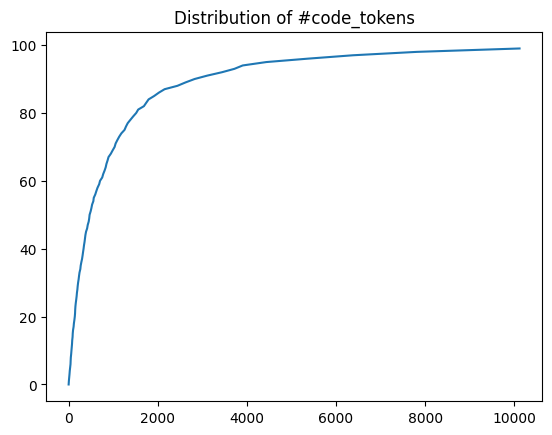

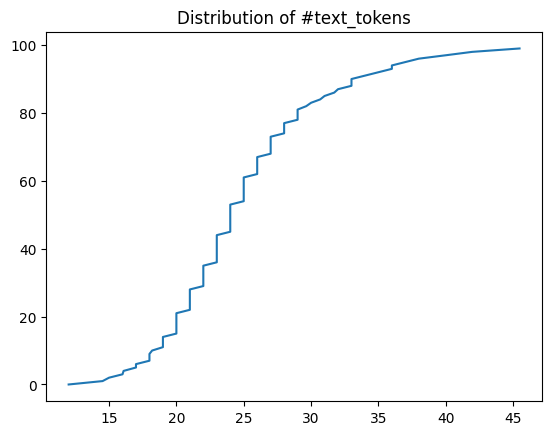

953it [02:22,  6.70it/s]
953it [00:01, 533.11it/s]
100%|██████████| 953/953 [00:00<00:00, 207936.94it/s]


Working on from_0.parquet


953it [02:14,  7.09it/s]
953it [00:01, 637.05it/s] 


953


100%|██████████| 2/2 [00:21<00:00, 10.92s/it]


In [6]:
num_samples_per_split, num_rows_per_file = None, 10000
# num_samples_per_split, num_rows_per_file = 100, 200 # for debugging

np.random.seed(10)
data = read_pt_dataset(num_samples_per_split) # columns: code, text, lang
data = preprocess(data)


add_structure(data) # columns: ast_leaves, dfg_edges, ast_leaf_tokens, ast_leaf_ranges

data['code_tokens'] = tokenize_codes_texts(list(data['code']))
data['text_tokens'] = tokenize_codes_texts(list(data['text']))
length_stats(data['code_tokens'], 'Distribution of #code_tokens')
length_stats(data['text_tokens'], 'Distribution of #text_tokens')
get_code_tokens_ranges(data) # columns: code_token_ranges -> list of (start,end) one for each code_token
data.drop(columns=['code', 'text'], inplace=True)
get_leaf_code_token_indices(data)
data.drop(columns=['ast_leaf_tokens', 'ast_leaf_ranges', 'code_tokens_ranges'], inplace=True)
for col in ['code_tokens', 'text_tokens']:
    data[col] = data[col].progress_apply(lambda l:','.join(list(map(str,l))))
data = data.sample(frac=1).reset_index(drop=True)
# columns -> ['lang', 'ast_leaves', 'dfg_edges', 'code_tokens', 'text_tokens', 'ast_leaf_code_token_idxs']

# do memory intensive part in chunks
save_dir = 'data/pretrain/'
os.makedirs(save_dir, exist_ok=True)
all_node_types = set()
for start in range(0,len(data),num_rows_per_file):
    print ('Working on from_'+str(start)+'.parquet')
    sub_data = data.iloc[start:start+num_rows_per_file].copy() # copy so that edits are not on data
    sub_node_types = get_ast_lr_paths_and_ll_sim(sub_data)
    all_node_types.update(sub_node_types)
    process_dfg_edges(sub_data)
    sub_data = sub_data[['code_tokens', 'text_tokens', 'lang',
                         'ast_leaf_code_token_idxs', 'll_sims', 'lr_paths_types',
                         'dfg_node_code_token_idxs', 'dfg_edges']]
    for col in ['ast_leaf_code_token_idxs', 'lr_paths_types', 'dfg_node_code_token_idxs', 'dfg_edges']:
        sub_data[col] = sub_data[col].apply(str)


    print(len(sub_data))


    sub_data.to_parquet(save_dir+'from_'+str(start)+'.parquet', engine='pyarrow')
del data

# convert node types to indices
all_node_types = sorted(list(all_node_types))
node_type_to_ind = {t:i for i,t in enumerate(all_node_types)}
pickle.dump(all_node_types, open(save_dir+'all_node_types.pkl', 'wb'))

for filename in tqdm(os.listdir(save_dir)):
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='pyarrow')
        sub_data['lr_paths_types'] = sub_data['lr_paths_types'].apply(
                        lambda s:str([[node_type_to_ind[t] for t in path]
                                      for path in parse_list_of_lists(s, type_=str)]))
        sub_data.to_parquet(save_dir+filename, engine='pyarrow')

In [7]:
# Reduce memory taken by ll_sims column by storing only upper triangles w/o diagnoals.
def upper_triangle(s):
    rows = s.split(';')[:-1]
    s = ''
    for i,row in enumerate(rows):
        s += ','.join(row.split(',')[i+1:]) + ';'
    return s[:-1]
pbar = tqdm(os.listdir(save_dir))
for filename in pbar:
    pbar.set_description(filename)
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='pyarrow')
        sub_data['ll_sims'] = sub_data['ll_sims'].apply(upper_triangle)
        sub_data.to_parquet(save_dir+filename, engine='pyarrow')

from_0.parquet: 100%|██████████| 2/2 [00:26<00:00, 13.03s/it]


100%|██████████| 953/953 [00:01<00:00, 609.81it/s]


Distrubution of fraction of leaf-root paths with ERROR node in one code


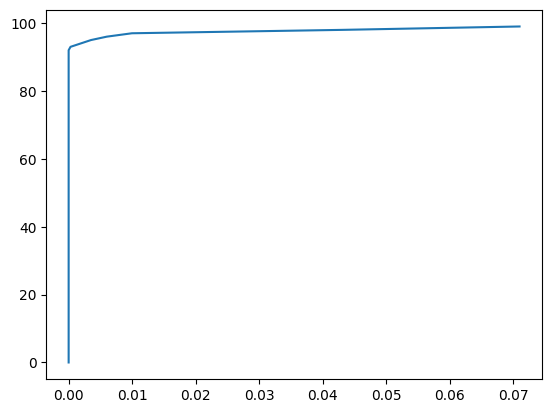

Distrubution of AST depth


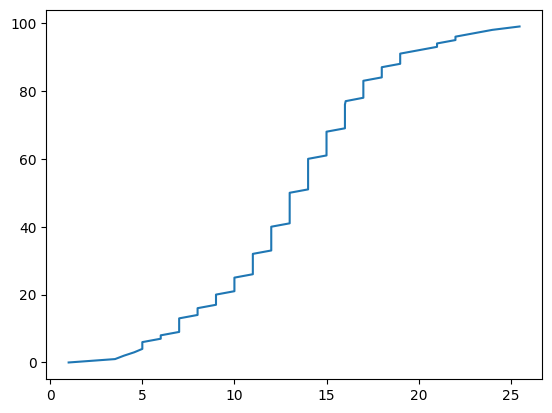

Distrubution of # ast leaves per code


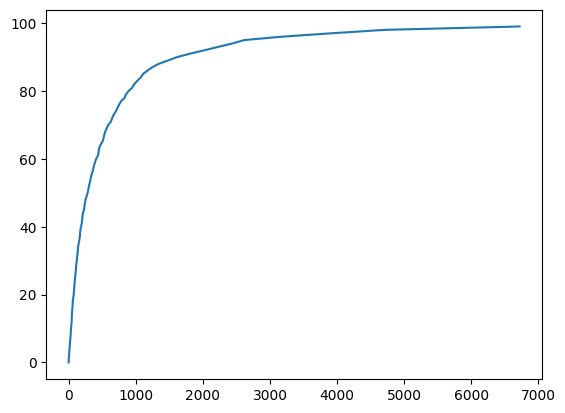

Distrubution of # dfg nodes per code


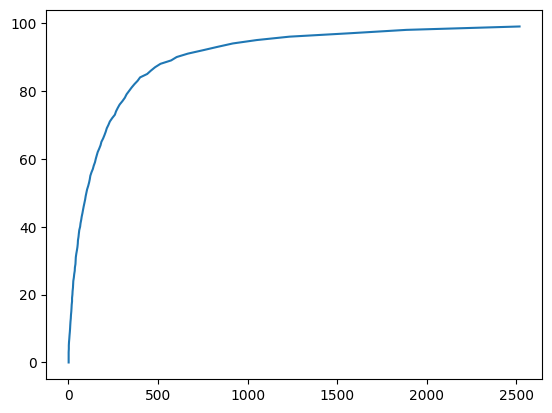

Distrubution of # dfg edges per code


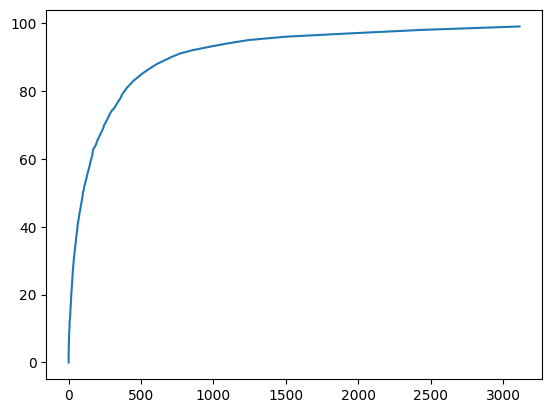

In [8]:
def some_more_stats(data):
    data['lr_paths_types'] = data['lr_paths_types'].progress_apply(lambda s:parse_list_of_lists(s, type_=int))
    node_types= pickle.load(open('data/pretrain/all_node_types.pkl','rb'))
    if 'ERROR' in node_types:
        error_node_idx = node_types.index('ERROR')
        num_error_nodes = data['lr_paths_types'].apply(lambda paths:np.mean([(np.array(path)==error_node_idx).max()
                                                                      for path in paths]))
        print ('Distrubution of fraction of leaf-root paths with ERROR node in one code')
        length_stats(num_error_nodes)
    print ('Distrubution of AST depth')
    length_stats(data['lr_paths_types'].apply(lambda paths:max([len(p) for p in paths])))

    print ('Distrubution of # ast leaves per code')
    length_stats(data['ast_leaf_code_token_idxs'].apply(lambda s:1+s.count('],')))
    print ('Distrubution of # dfg nodes per code')
    length_stats(data['dfg_node_code_token_idxs'].apply(lambda s:1+s.count('],')))
    print ('Distrubution of # dfg edges per code')
    def num_dfg_edges(s):
        if s=='[]':
            return 0
        return sum([t.split(', ',maxsplit=1)[1].count(',')+1 for t in s[1:-2].split('),')])
    length_stats(data['dfg_edges'].apply(num_dfg_edges))

data = []
save_dir = 'data/pretrain/'
for filename in tqdm(os.listdir(save_dir)):
    if filename.startswith('from_'):
        sub_data = pd.read_parquet(save_dir+filename, engine='pyarrow')
        data.append(sub_data)

data = pd.concat(data)

some_more_stats(data)